In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from pathlib import Path
from tqdm import tqdm

# Import utility function for concatenating the robot state
from furniture_bench.robot.robot_state import filter_and_concat_robot_state, ROBOT_STATES, ROBOT_STATE_DIMS
from src.data.utils import zipped_img_generator

In [3]:
def print_stats(data):
    print(f"min: {np.min(data)}, max: {np.max(data)}, mean: {np.mean(data)}, std: {np.std(data)}")


def make_hist(data, title=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)

    ax1.hist(data, bins=100)
    ax1.set_title("Linear scale")

    ax2.hist(data, bins=100, log=True)
    ax2.set_title("Log scale")

## Look at the robot_state data in the raw sim data

In [4]:
root = Path("/data/scratch/ankile/furniture-data/data/raw/sim/image")
pickle_files = list(root.rglob("*.pkl"))

len(pickle_files)

490

In [5]:
robot_states = []
actions = []

for file in tqdm(pickle_files):
    with open(file, "rb") as f:
        data = pickle.load(f)
    robot_states.extend([filter_and_concat_robot_state(o["robot_state"]) for o in data["observations"]])
    actions.extend(data["actions"])

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 490/490 [00:34<00:00, 14.01it/s]


In [6]:
robot_states = np.array(robot_states)

In [7]:
# Make the x-axis labels
labels = []

for state in ROBOT_STATES:
    for dim in range(ROBOT_STATE_DIMS[state]):
        labels.append(f"{state}_{dim}")

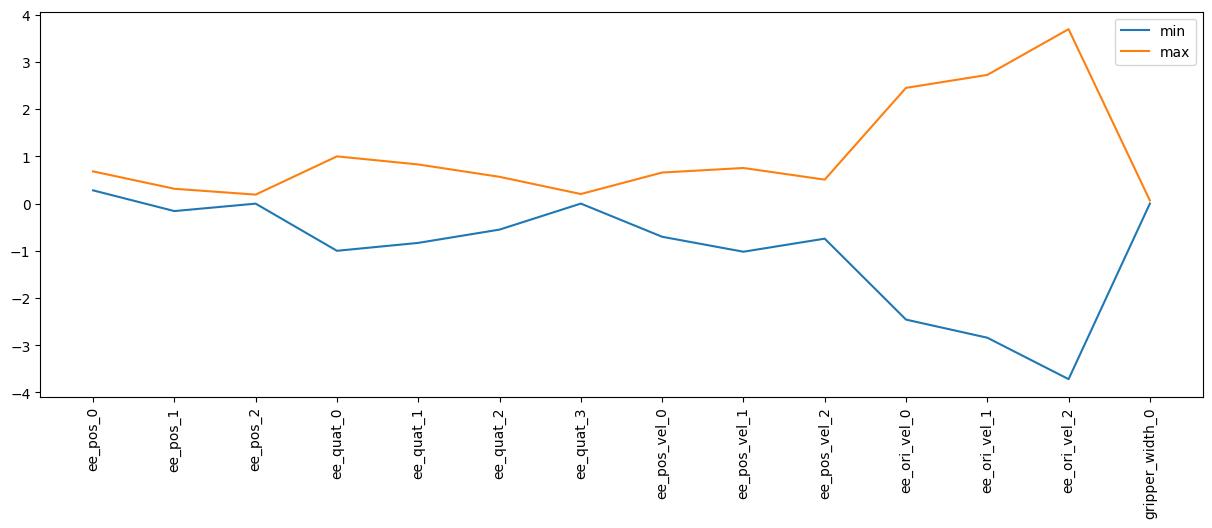

In [8]:
# Plot the min and the max across the robot states
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

ax1.plot(np.min(robot_states, axis=0))
ax1.plot(np.max(robot_states, axis=0))
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=90)
ax1.legend(["min", "max"])

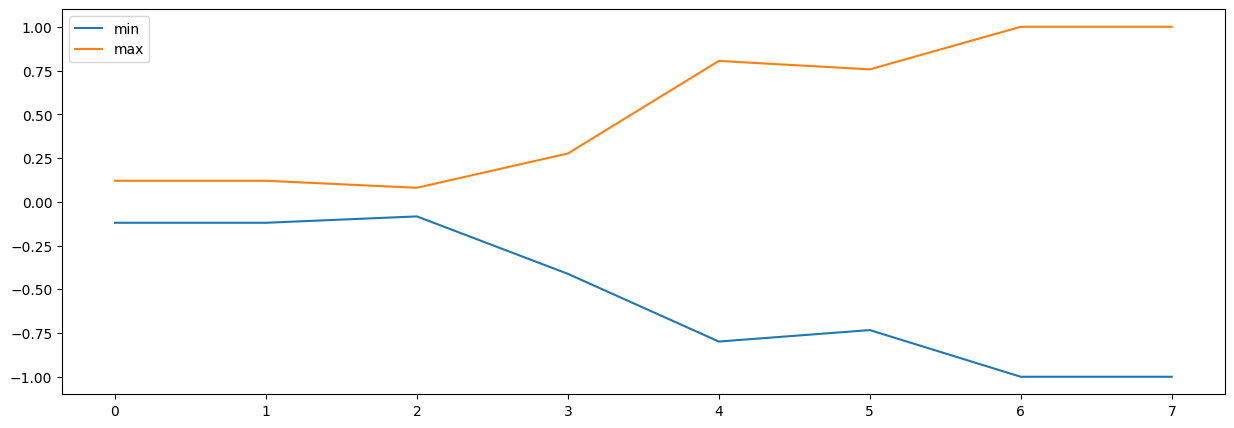

In [9]:
# Plot the min and the max across the actions
actions = np.array(actions)

fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

ax1.plot(np.min(actions, axis=0))
ax1.plot(np.max(actions, axis=0))
ax1.legend(["min", "max"])

In [10]:
# Look at min and max for gripper width
np.min(robot_states[:, -1], axis=0), np.max(robot_states[:, -1], axis=0)

(4.7516914e-05, 0.065)

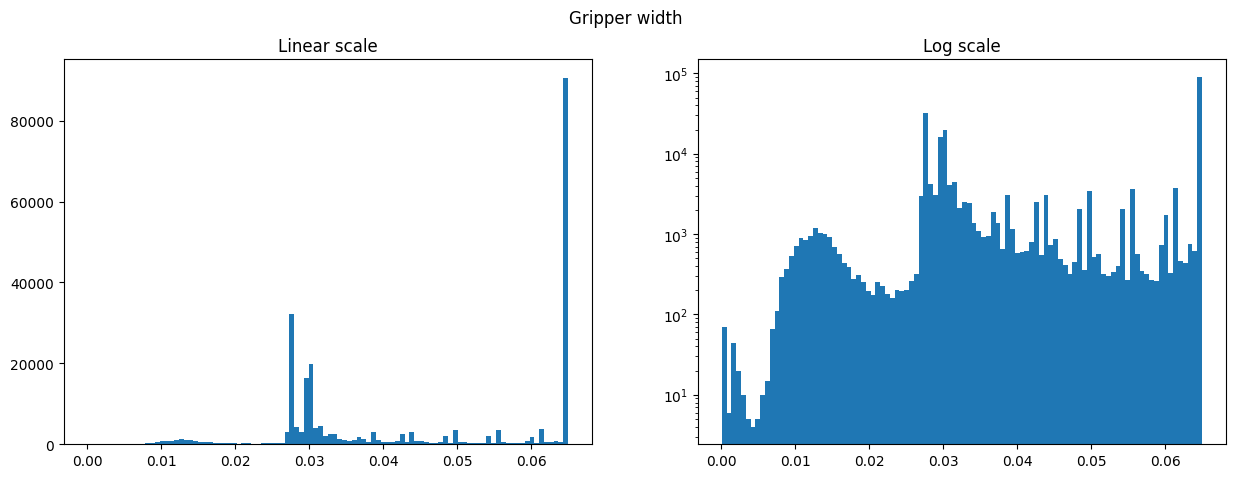

In [11]:
# Make histogram for gripper width
make_hist(robot_states[:, -1], title="Gripper width")

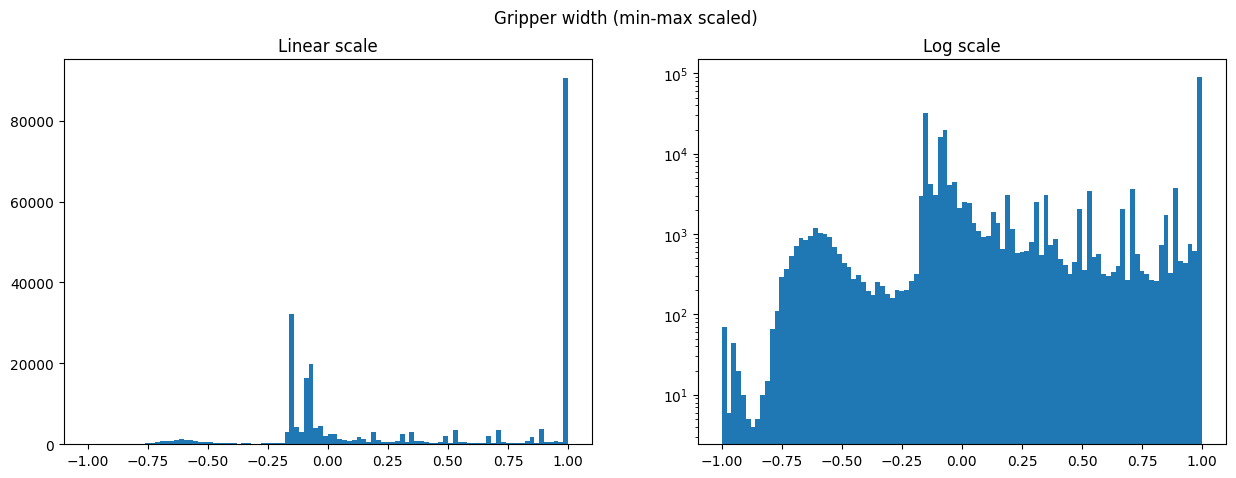

In [12]:
# MinMax scale [-1, 1] the gripper width and make histogram
gripper_width = robot_states[:, -1]
gripper_width = (gripper_width - np.min(gripper_width)) / (np.max(gripper_width) - np.min(gripper_width))
gripper_width = gripper_width * 2 - 1

make_hist(gripper_width, title="Gripper width (min-max scaled)")

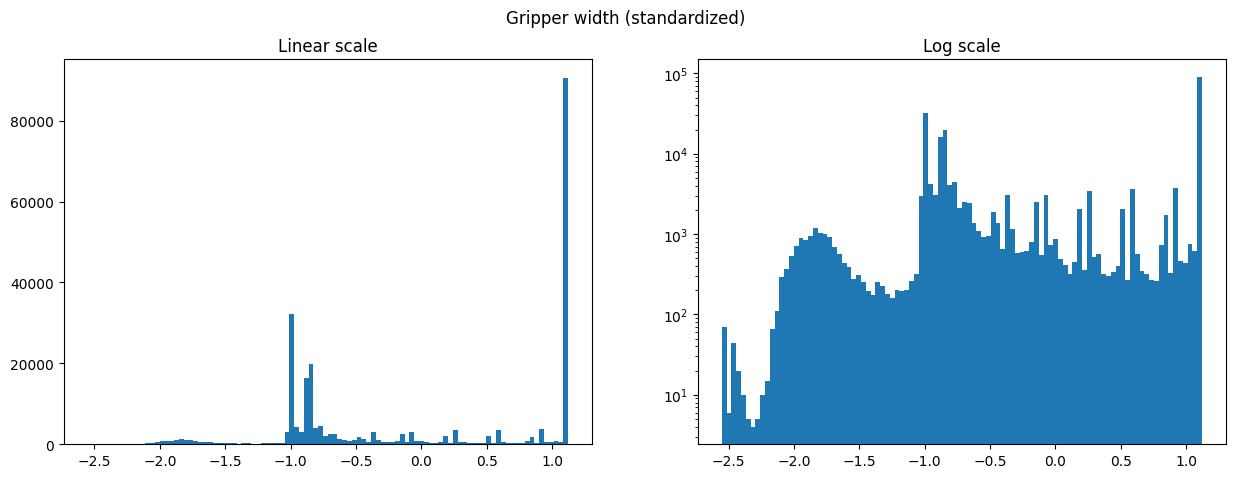

In [13]:
# Standardize the gripper width and make histogram
gripper_width = robot_states[:, -1]
gripper_width = (gripper_width - np.mean(gripper_width)) / np.std(gripper_width)

make_hist(gripper_width, title="Gripper width (standardized)")

## Look at the robot_state data in the raw real data

In [14]:
lamp = "/data/scratch/ankile/furniture-data/data/raw/real/image/lamp/low/lamp.tar.gz"
gen = zipped_img_generator(
    filename=lamp,
    max_samples=100,
)

robot_states_real = []
actions_real = []

for data in tqdm(gen, total=100):
    obs = data["observations"]
    robot_states_real.extend([filter_and_concat_robot_state(o["robot_state"]) for o in obs])
    actions_real.extend(data["actions"])

robot_states_real = np.array(robot_states_real)
robot_states_real.shape

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


(61422, 14)

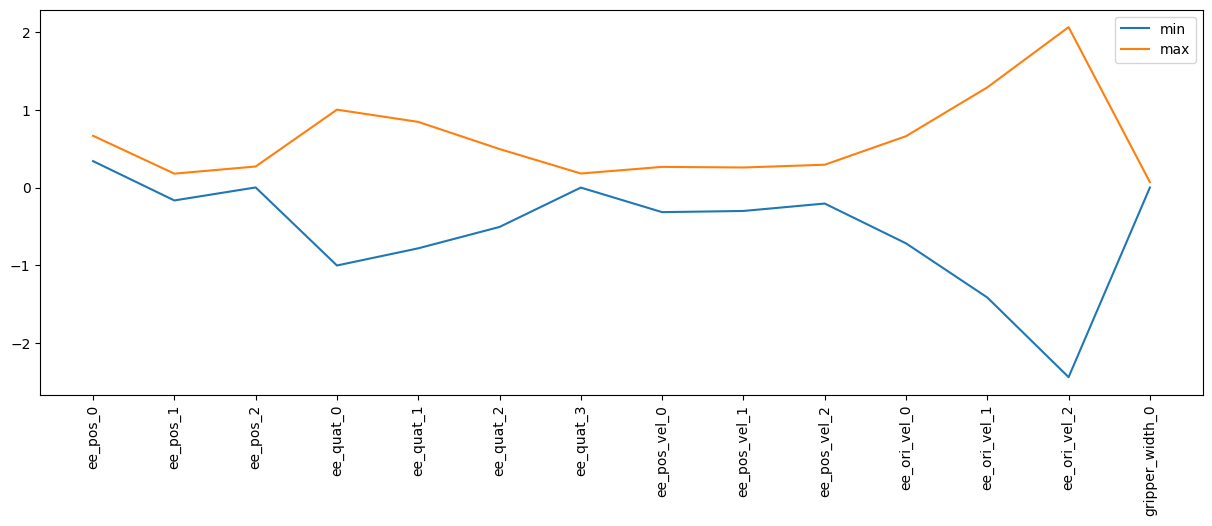

In [15]:
# Plot the min and the max across the robot states
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

ax1.plot(np.min(robot_states_real, axis=0))
ax1.plot(np.max(robot_states_real, axis=0))
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=90)
ax1.legend(["min", "max"])

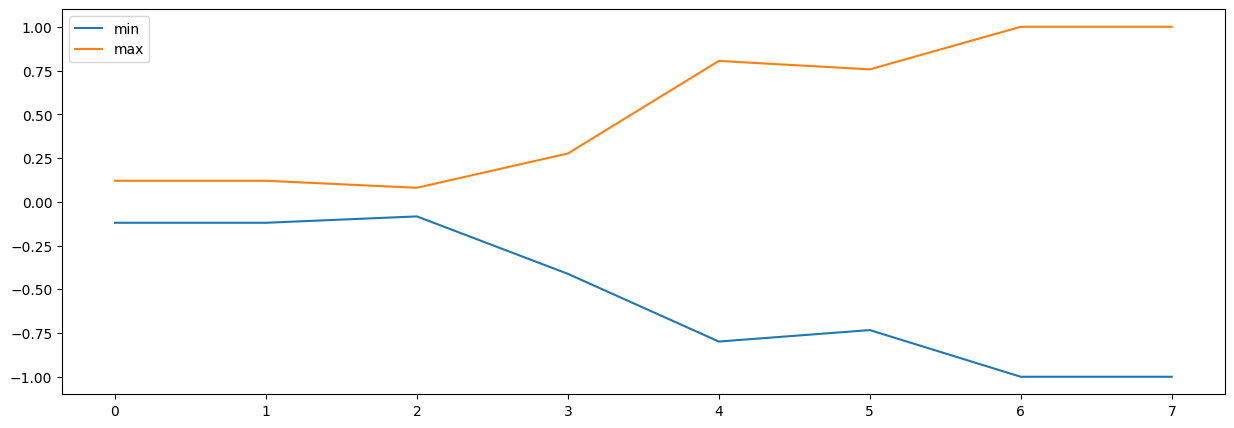

In [18]:
# Plot the min and the max across the actions
actions_real = np.array(actions_real)

fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

ax1.plot(np.min(actions, axis=0))
ax1.plot(np.max(actions, axis=0))
ax1.legend(["min", "max"])

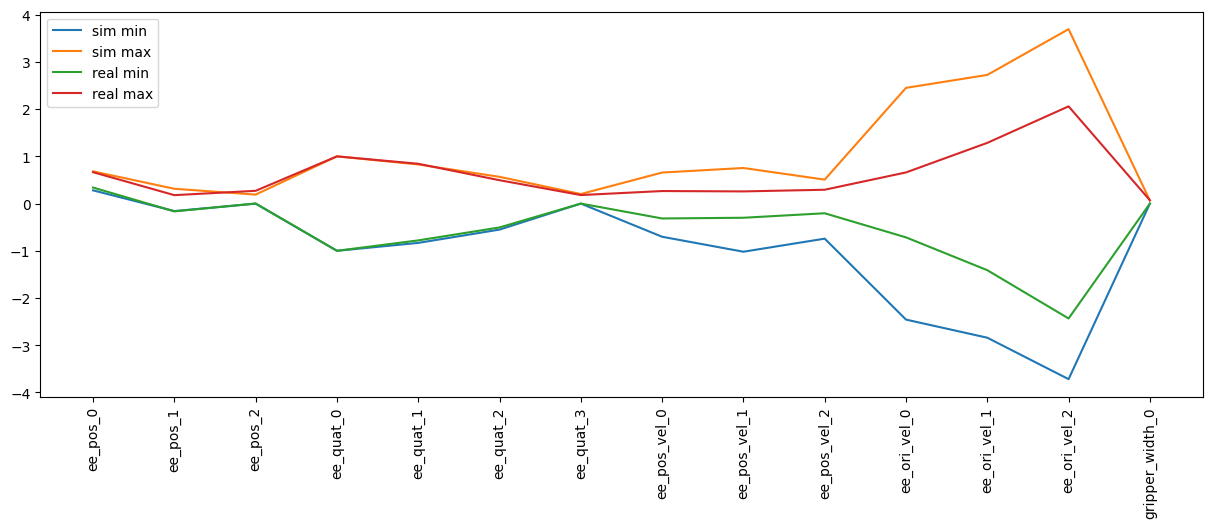

In [16]:
# Plot the same as above but for both real and sim in the same plot
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

ax1.plot(np.min(robot_states, axis=0))
ax1.plot(np.max(robot_states, axis=0))
ax1.plot(np.min(robot_states_real, axis=0))
ax1.plot(np.max(robot_states_real, axis=0))
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=90)
ax1.legend(["sim min", "sim max", "real min", "real max"])

## Calculate the stats for robot_state and action from both sim and real data

### Robot_state

In [19]:
# Calculate min and max for robot_state for both real and sim
all_robot_states = np.concatenate([robot_states, robot_states_real], axis=0)
np.min(all_robot_states, axis=0)

array([ 2.80025989e-01, -1.65265590e-01, -1.33207440e-03, -9.99999881e-01,
       -8.32509935e-01, -5.51004350e-01,  1.40711887e-08, -7.02747107e-01,
       -1.01964152e+00, -7.42725849e-01, -2.45710993e+00, -2.84063244e+00,
       -3.71836829e+00,  4.75169145e-05])

In [20]:
np.max(all_robot_states, axis=0)

array([0.68205643, 0.31372252, 0.27053252, 0.99999988, 0.8431676 ,
       0.56648922, 0.20231877, 0.65723258, 0.75370288, 0.50734419,
       2.4507556 , 2.72471213, 3.6940937 , 0.07003613])

### Action

In [21]:
# Calculate min and max for actions for both real and sim
all_actions = np.concatenate([actions, actions_real], axis=0)
np.min(all_actions, axis=0)

array([-0.11999873, -0.11999782, -0.0910784 , -0.41173494, -0.7986815 ,
       -0.73318267, -1.00000012, -1.        ])

In [22]:
np.max(all_actions, axis=0)

array([0.11999907, 0.11999977, 0.1       , 0.27584794, 0.80490655,
       0.75659704, 1.00000024, 1.        ])